In [201]:
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import  BinaryAccuracy, FalsePositives, TruePositives, TrueNegatives, \
                                      FalseNegatives, AUC #, Recall, Precision,
sys.path.insert(1, "/users/rserage/Zoon0PredV/bin/")
from metrics_helper import MatthewsCorrelationCoefficient

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore, CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
# from tf_keras_vis.scorecam import Scorecam

from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

from tf_keras_vis.utils import num_of_gpus

%reload_ext autoreload
%autoreload 2

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPU(s)'.format(gpus))

Tensorflow recognized 0 GPU(s)


In [191]:
replace2linear = ReplaceToLinear()

intermdiate4gradcam = model_modifiers.ExtractIntermediateLayerForGradcam()
# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-2].activation = tf.keras.activations.linear

In [3]:
def load_compile_model(model_dir: str):
    model = tf.keras.models.load_model(model_dir, compile=False)
    thresh=0.65
    # recall = Recall(name = "Recall", thresholds=thresh)
    # precision = Precision(name = "Precision", thresholds=thresh)
    accuracy = BinaryAccuracy(threshold=thresh)
    false_positives = FalsePositives(name="FP",thresholds=thresh)
    true_positives = TruePositives(name="TP", thresholds=thresh)
    true_negatives = TrueNegatives(name="TN", thresholds=thresh)
    false_negatives = FalseNegatives(name="FN", thresholds=thresh)
    methewsCC = MatthewsCorrelationCoefficient(name="MCC", thresholds=thresh)
    auc_roc = AUC(name='AUC')

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.015),
        metrics=[
            accuracy,
            # recall,
            # precision,
            false_positives,
            true_positives,
            true_negatives,
            false_negatives,
            methewsCC,
            auc_roc
    ])
    return model

# Attensions for interpretation

In [ ]:
"/scratch2/users/rserage/ZoonosisData/test/human-true/human_true_A0A023HK88_Hemagglutinin.png"
"/scratch2/users/rserage/ZoonosisData/test/human-false/human_false_A0A023PM26_Spike.png"
"/scratch2/users/rserage/ZoonosisData/test/human-true/human_true_A0A060A1T6_Capsid.png"
"/scratch2/users/rserage/ZoonosisData/test/human-false/human_false_A0A023R6W2_Capsid.png"


In [241]:
def load_samples(image_paths, target_size=(128,128)):

    read_img = lambda image: load_img(image, target_size=target_size, color_mode='grayscale')

    images = [np.array(read_img(image)) for image in image_paths]

    images = np.asarray(images)

    images_array_new_shape = tuple([images.shape[0]] + list(target_size) + [1])

    images = images.reshape(images_array_new_shape)

    X = images/255.0
    
    return (images, X)

In [320]:
def get_attention_maps(model, model_modifier_finction, samples, score):
    pen_ultim = -1
    # Create Saliency object.
    saliency = Saliency(model,
                        model_modifier=model_modifier_function,
                        clone=True)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(score,
                            samples,
                            smooth_samples=100, # The number of calculating gradients iterations.
                            smooth_noise=0.1) # noise spread level.

    #######################################################################

    # Create GradCAM++ object
    gradcam = GradcamPlusPlus(model,
                              model_modifier=model_modifier_function,
                              clone=True)

    # Generate heatmap with GradCAM++
    cam = gradcam(score,
                  samples,
                  penultimate_layer=pen_ultim
                 )

    #######################################################################

    scorecam = Scorecam(model,
                        model_modifier=model_modifier_function)

    # Generate heatmap with Faster-ScoreCAM
    s_cam = scorecam(score,
                   samples,
                   penultimate_layer=pen_ultim,
                   max_N=-1)
    
    #######################################################################

    maps = {
        "Saliency map": saliency_map,
        "GradCam++": cam,
        "Score Cam": s_cam}
    
    return maps

In [187]:
def generate_heatmap(axes, image, att_map, i):
    axes.imshow(image, cmap= plt.cm.binary)
    heatmap = np.uint8(cm.jet(att_map[i])[..., :3] * 255)
    axes.imshow(heatmap, cmap='jet', alpha=0.5)
    axes.tick_params(
        axis='both',
        which='both',
        left=False,
        right=False,
        labelleft=False,
        bottom=False,
        top=False,
        labelbottom=False
    )

In [246]:
main_dir = "/users/rserage/scratch2/"

In [309]:
path_to_model = main_dir + "RNA-MetazoaZoonosisData/model/"

model = load_compile_model(path_to_model)

In [314]:
base_path = main_dir + "ZoonosisData/test/"
image_titles = ['Hemagglutinin',
                'Spike',
                'Capsid Human true',
                'Capsid Human false'
               ]

image_paths = [base_path + 'human-true/human_true_A0A023HK88_Hemagglutinin.png',
               base_path + 'human-false/human_false_A0A023PM26_Spike.png',
               base_path + 'human-true/human_true_A0A060A1T6_Capsid.png',
               base_path + 'human-false/human_false_A0A023R6W2_Capsid.png'
              ]

scores = BinaryScore([1,0,1,0])

In [315]:
images, processed_samples = load_samples(image_paths)
# model_modifier_function
maps = get_attention_maps(model, replace2linear, processed_samples, scores)

attention_maps = {"Original": images}

attention_maps.update(maps)

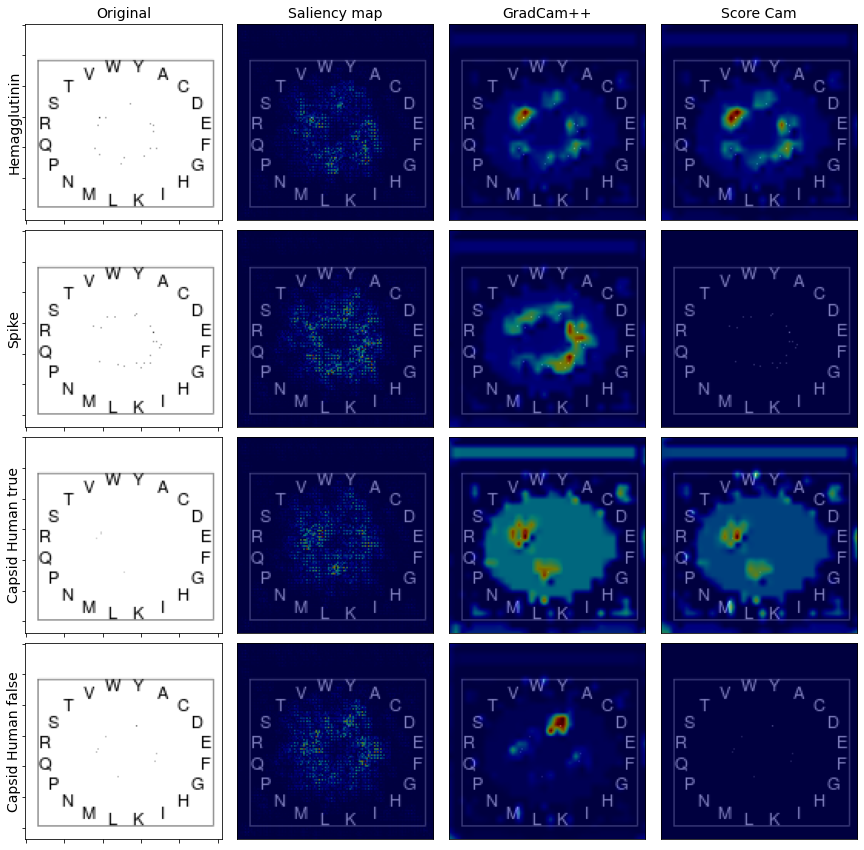

In [321]:
fig = plt.figure(figsize=(10,10), dpi=1200)

gs = GridSpec(nrows=len(image_titles), ncols=len(attention_maps),
              # left=0.05,
              # right=0.08,
              wspace=0.02,
              hspace=0.02
             )

for i, title in enumerate(image_titles):

    for j, (map_name, att_map) in enumerate(attention_maps.items()):
        
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(map_name, fontsize=14) # if on first column
        
        if map_name == "Original":
            ax.imshow(images[i], cmap="gray")
            ax.set_ylabel(title, rotation=90, fontsize=14)
            ax.tick_params(labelbottom=False, labelleft=False)
        elif map_name == "Saliency map":
            generate_heatmap(ax, images[i], att_map, i)
        elif map_name == "GradCam++":
            generate_heatmap(ax, images[i], att_map, i)
        elif map_name == "Score Cam": # Default to score cam
            generate_heatmap(ax, images[i], att_map, i)       
        
        
# plt.tight_layout()
# plt.savefig("Attention_maps.png")

In [324]:
dirs = os.listdir(main_dir)

dirs_absolute_paths = [os.path.join(main_dir, fol) for fol in dirs]

data_dirs = list(filter(lambda x: os.path.isdir(x) & x.__contains__("Data"), dirs_absolute_paths))

model_paths = [os.path.join(path, 'model') for path in data_dirs]

model_names = [path.split("/")[-1] for path in data_dirs]

In [325]:
models = [load_compile_model(path) for path in model_paths]

In [329]:
image_title = 'Hemagglutinin'

image_paths = [base_path + 'human-true/human_true_A0A060A1T6_Capsid.png']

image_array, processed_image_array = load_samples(image_paths)

score = BinaryScore([0])

In [330]:
list_models_attention = list()

model_attentions = [
        get_attention_maps(
            model, replace2linear,
            processed_image_array, score
        ) for model in models
]
for model_attention in model_attentions:
    atts = dict(Original=image_array)
    atts.update(model_attention)
    list_models_attention.append(atts.copy())

/usr/local/lib/python3.6/dist-packages/IPython/kernel/__main__.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


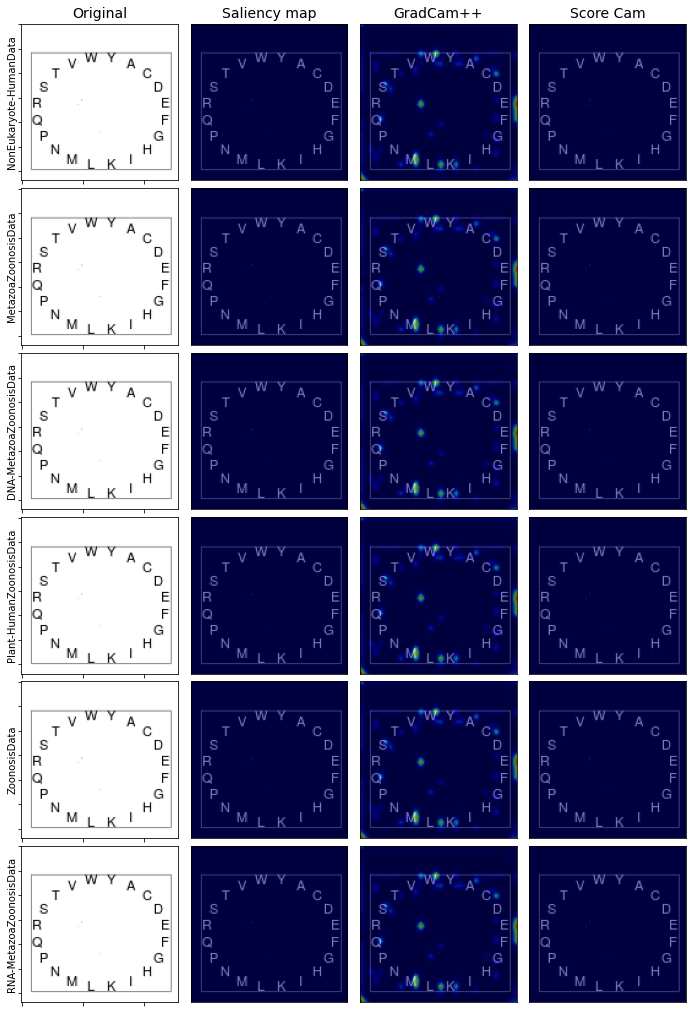

In [331]:
fig = plt.figure(figsize=(12,18))

gs1 = GridSpec(
    nrows=len(models),
    ncols=len(list_models_attention[0]),
    wspace=0.05,
    hspace=0.05
)
for i, name in enumerate(model_names):
    for attention in list_models_attention:
        for j, (map_name, att_map) in enumerate(attention.items()):
            ax1 = fig.add_subplot(gs1[i, j])
            if i == 0:
                ax1.set_title(map_name, fontsize=14) # if on first column

            if map_name == "Original":
                ax1.imshow(image_array[0], cmap="gray")
                ax1.set_ylabel(name, rotation=90, fontsize=10)
                ax1.tick_params(labelbottom=False, labelleft=False)
            elif map_name == "Saliency map":
                generate_heatmap(ax1, image_array[0], att_map, 0)
            elif map_name == "GradCam++":
                generate_heatmap(ax1, image_array[0], att_map, 0)
            elif map_name == "Score Cam":
                generate_heatmap(ax1, image_array[0], att_map, 0)

# plt.savefig("Attention_maps.png")